# Portfolio Optimization

## Import needed libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Initialize optimize.vicbee.net client

In [2]:
import sys
sys.path.append("..")

In [3]:
import pyoptimum # for easy access to the optimmize.vicbee.net api

In [4]:
username = 'demo@optimize.vicbee.net'
password = 'optimize'
client = pyoptimum.Client(username=username, password=password)

# Classic Markowitz Portfolio Optimization

In the classic Markowitz optimal portfolio optimization (Markowitz, 1952), one seeks to determine 
* $x$: a vector of porfolio positions

that minimize the total portfolio variance given:
* $r$: the vector of expected returns;
* $Q$: the covariance matrix of the returns;
* $\mu$: the desired portfolio return.

The problem can be formulated mathematically as the following Quadratic Program (QP):
$$
\begin{aligned}
  \min_{x} \quad & x^T Q x \\
  \text{s.t.} \quad & r^T x = \mu \\
  & \sum_i{x_i} = 1 
\end{aligned}
$$

In the next cells we will setup and solve one such problem using the [Optimize API](https://optmize.vicbee.net/api/ui). 

Data for this problem is taken from Elton and Gruber, 1995.

## Setup data using pandas

In [5]:
data = [
    ['S & P',14.0,18.5],
    ['Bonds',6.5,5.0],
    ['Canadian',11.0,16.0],
    ['Japan',14.0,23.0],
    ['Emerging Markets',16.0,30.0],
    ['Pacific',18.0,26.0],
    ['Europe',12.0,20.0],
    ['Small Stocks',17.0,24.0] 
]
assets = pd.DataFrame(data, columns=['Label', 'Return (%)', 'STD (%)'])
assets

,Label,Return (%),STD (%)
0,S & P,14.0,18.5
1,Bonds,6.5,5.0
2,Canadian,11.0,16.0
3,Japan,14.0,23.0
4,Emerging Markets,16.0,30.0
5,Pacific,18.0,26.0
6,Europe,12.0,20.0
7,Small Stocks,17.0,24.0


In [6]:
n = len(assets)
data = np.array([
    [1,.45,.7,.2,.64,.3,.61,.79],
    [.45,1,.27,-.01,.41,.01,.13,.28],
    [.7,.27,1,.14,.51,.29,.48,.59],
    [.2,-.01,.14,1,.25,.73,.56,.13],
    [.64,.41,.51,.25,1,.28,.61,.75],
    [.3,.01,.29,.73,.28,1,.54,.16],
    [.61,.13,.48,.56,.61,.54,1,.44],
    [.79,.28,.59,.13,.75,.16,.44,1]
])
cov = pd.DataFrame(data=data, columns=assets.Label.values, index=assets.Label.values)
cov

,S & P,Bonds,Canadian,Japan,Emerging Markets,Pacific,Europe,Small Stocks
S & P,1.00,0.45,0.70,0.20,0.64,0.30,0.61,0.79
Bonds,0.45,1.00,0.27,-0.01,0.41,0.01,0.13,0.28
Canadian,0.70,0.27,1.00,0.14,0.51,0.29,0.48,0.59
Japan,0.20,-0.01,0.14,1.00,0.25,0.73,0.56,0.13
Emerging Markets,0.64,0.41,0.51,0.25,1.00,0.28,0.61,0.75
Pacific,0.30,0.01,0.29,0.73,0.28,1.00,0.54,0.16
Europe,0.61,0.13,0.48,0.56,0.61,0.54,1.00,0.44
Small Stocks,0.79,0.28,0.59,0.13,0.75,0.16,0.44,1.00


## Solve problem using the Optmize API

In [7]:
# vector of expected returns
r = assets['Return (%)'].values

# covariance matrix
sigmas = np.diag(assets['STD (%)'].values)
Q = sigmas @ cov.values @ sigmas

# expected return
mu = 14

## Submit problem to the api

In [8]:
# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu
}
sol = client.call('portfolio', data)

### Got solution?

In [9]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Optimal (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    pd.options.display.float_format = '{:,.2f}'.format
    assets['Optimal (%)'] = 100*np.array(sol['x'])
assets

> Problem is feasible
  * mu = 14.000%, std = 12.930% (optimal)


,Label,Return (%),STD (%),Optimal (%)
0,S & P,14.00,18.50,5.32
1,Bonds,6.50,5.00,36.98
2,Canadian,11.00,16.00,-3.63
3,Japan,14.00,23.00,6.90
4,Emerging Markets,16.00,30.00,-11.96
5,Pacific,18.00,26.00,33.68
6,Europe,12.00,20.00,-11.51
7,Small Stocks,17.00,24.00,44.22


By default, the solution vector adds to one, each number being interpreted as the fraction of the available budget that should be invested in order to obtain the calculated optimal portfolio. Note that we used numpy to convert that to a percentage before displaying the solution.

## Solution without short sales

Next we will modify this problem by adding features and constraints that will change the solution.

First note that for the required level of return, the optimal solution has some positions which negative. One can prevent that by adding the following option to the portfolio optimizer

In [10]:
# options
options = {
    'short': False
}

and calling the API once again

In [11]:
# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'options': options
}
sol = client.call('portfolio', data)

### Got solution?

In [12]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['No Shorts (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    assets['No Shorts (%)'] = 100*np.array(sol['x'])
assets

> Problem is feasible
  * mu = 14.000%, std = 13.365% (optimal)


,Label,Return (%),STD (%),Optimal (%),No Shorts (%)
0,S & P,14.00,18.50,5.32,0.00
1,Bonds,6.50,5.00,36.98,30.86
2,Canadian,11.00,16.00,-3.63,0.00
3,Japan,14.00,23.00,6.90,2.68
4,Emerging Markets,16.00,30.00,-11.96,0.00
5,Pacific,18.00,26.00,33.68,32.10
6,Europe,12.00,20.00,-11.51,0.00
7,Small Stocks,17.00,24.00,44.22,34.35


## Accounting for cashflow

Now suppose that one has an initial portfolio that they would like to rebalance, or buy or sell more assets.

In this case, one starts with an initial positions, for example:

In [13]:
assets['Initial (%)'] = [20, 30, 0, 20, 0, 10, 0, 20]
assets

,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%)
0,S & P,14.00,18.50,5.32,0.00,20
1,Bonds,6.50,5.00,36.98,30.86,30
2,Canadian,11.00,16.00,-3.63,0.00,0
3,Japan,14.00,23.00,6.90,2.68,20
4,Emerging Markets,16.00,30.00,-11.96,0.00,0
5,Pacific,18.00,26.00,33.68,32.10,10
6,Europe,12.00,20.00,-11.51,0.00,0
7,Small Stocks,17.00,24.00,44.22,34.35,20


Optimal portfolio should not change if one holds assets or not, so the answers obtained so far should not be affected by the existing holdings.

However, imagine that one has cash to invest and would like to know what is the best solution for investing the additional money without selling any of the existing stock.

One can take that scenario into account by adding the initial portfolio and the desired cashflow, say equivalent to 30% of the existing portfolio, along with an option for not selling any stock.

In [14]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

# cashflow
cashflow = 40/100

# expected return
mu = 14

# options
options = {
    'sell': False 
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('portfolio', data)

### Got solution?

In [15]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Buys (%)'] = np.nan
    assets['After Cashflow (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    x = np.array(sol['x'])
    assets['Buys (%)'] = 100*(x - x0)/cashflow
    assets['After Cashflow (%)'] = 100*x/x.sum()
assets

> Problem is feasible
  * mu = 14.000%, std = 13.586% (optimal)


,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%),Buys (%),After Cashflow (%)
0,S & P,14.00,18.50,5.32,0.00,20,-0.00,14.29
1,Bonds,6.50,5.00,36.98,30.86,30,3.98,22.57
2,Canadian,11.00,16.00,-3.63,0.00,0,-0.00,-0.00
3,Japan,14.00,23.00,6.90,2.68,20,-0.00,14.29
4,Emerging Markets,16.00,30.00,-11.96,0.00,0,-0.00,-0.00
5,Pacific,18.00,26.00,33.68,32.10,10,54.29,22.65
6,Europe,12.00,20.00,-11.51,0.00,0,-0.00,-0.00
7,Small Stocks,17.00,24.00,44.22,34.35,20,41.73,26.21


As one add constraints, it is often the case that certain problems will not be solvable.

For example, if one lowers the ammount available for investment in the above cashflow problem a solution might not exist.

For example, lowering the available cashflow to 10%.

In [16]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

# cashflow
cashflow = 10/100

# expected return
mu = 14

# options
options = {
    'sell': False 
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('portfolio', data)

### Got solution?

In [17]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Buys (%)'] = np.nan
    assets['After Cashflow (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    x = np.array(sol['x'])
    assets['Buys (%)'] = 100*(x - x0)/cashflow
    assets['After Cashflow (%)'] = 100*x/x.sum()
assets

> Problem is infeasible


,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%),Buys (%),After Cashflow (%)
0,S & P,14.00,18.50,5.32,0.00,20,nan,nan
1,Bonds,6.50,5.00,36.98,30.86,30,nan,nan
2,Canadian,11.00,16.00,-3.63,0.00,0,nan,nan
3,Japan,14.00,23.00,6.90,2.68,20,nan,nan
4,Emerging Markets,16.00,30.00,-11.96,0.00,0,nan,nan
5,Pacific,18.00,26.00,33.68,32.10,10,nan,nan
6,Europe,12.00,20.00,-11.51,0.00,0,nan,nan
7,Small Stocks,17.00,24.00,44.22,34.35,20,nan,nan


Of course the reason why the problem has no solution is because the return of the initial portfolio

In [18]:
print('{:.2f}'.format(r @ x0))

12.75


 is much lower than the return asked during optimization, which was of 14%.
 
 It may be possible to obtain solutions with more modest cashflows if one asks for more modest returns.
 
 For example, a modest improvement in return from 12.75% to 13% is available with a 10% cashflow:

In [19]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

# cashflow
cashflow = 10/100

# lower return
mu = 13

# options
options = {
    'sell': False 
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'mu': mu,
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('portfolio', data)

### Got solution?

In [20]:
if sol['status']=='infeasible':
    print('> Problem is infeasible')
    assets['Buys (%)'] = np.nan
    assets['After Cashflow (%)'] = np.nan
else:
    print('> Problem is feasible')
    print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(mu, math.sqrt(sol['obj']), sol['status']))
    x = np.array(sol['x'])
    assets['Buys (%)'] = 100*(x - x0)/cashflow
    assets['After Cashflow (%)'] = 100*x/x.sum()
assets

> Problem is feasible
  * mu = 13.000%, std = 12.221% (optimal)


,Label,Return (%),STD (%),Optimal (%),No Shorts (%),Initial (%),Buys (%),After Cashflow (%)
0,S & P,14.00,18.50,5.32,0.00,20,0.00,18.18
1,Bonds,6.50,5.00,36.98,30.86,30,20.97,29.18
2,Canadian,11.00,16.00,-3.63,0.00,0,0.00,0.00
3,Japan,14.00,23.00,6.90,2.68,20,0.00,18.18
4,Emerging Markets,16.00,30.00,-11.96,0.00,0,-0.00,-0.00
5,Pacific,18.00,26.00,33.68,32.10,10,70.20,15.47
6,Europe,12.00,20.00,-11.51,0.00,0,-0.00,-0.00
7,Small Stocks,17.00,24.00,44.22,34.35,20,8.83,18.98


# The efficient frontier

In [21]:
# vector of expected returns
r = assets['Return (%)'].values

# covariance matrix
sigmas = np.diag(assets['STD (%)'].values)
Q = sigmas @ cov.values @ sigmas

# options
options = {
    'number_of_points': 20
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'options': options
}
sol = client.call('frontier', data)

### Got solution?

In [22]:
frontier = sol['frontier']
m = len(frontier)
mu0 = np.zeros((m,))
var0 = np.zeros((m,))
pos0 = np.zeros((m, n))
for i, e in enumerate(frontier):
    point = e['sol']
    mu0[i] = e['mu']
    var0[i] = point['obj']
    pos0[i, :] = point['x']
    if point['obj'] is not None:
        print('  {}. mu = {:.3f}%, std = {:.3f}% ({})'.format(i+1, mu0[i], math.sqrt(var0[i]), point['status']))
    else:
        print('  {}. mu = {:.3f}%, std = --- ({})'.format(i+1, mu0[i], point['status']))

  1. mu = 6.413%, std = 3.913% (optimal)
  2. mu = 7.023%, std = 4.036% (optimal)
  3. mu = 7.633%, std = 4.386% (optimal)
  4. mu = 8.243%, std = 4.913% (optimal)
  5. mu = 8.853%, std = 5.569% (optimal)
  6. mu = 9.463%, std = 6.312% (optimal)
  7. mu = 10.072%, std = 7.116% (optimal)
  8. mu = 10.682%, std = 7.962% (optimal)
  9. mu = 11.292%, std = 8.838% (optimal)
  10. mu = 11.902%, std = 9.736% (optimal)
  11. mu = 12.512%, std = 10.651% (optimal)
  12. mu = 13.121%, std = 11.578% (optimal)
  13. mu = 13.731%, std = 12.515% (optimal)
  14. mu = 14.341%, std = 13.459% (optimal)
  15. mu = 14.951%, std = 14.410% (optimal)
  16. mu = 15.561%, std = 15.366% (optimal)
  17. mu = 16.171%, std = 16.326% (optimal)
  18. mu = 16.780%, std = 17.289% (optimal)
  19. mu = 17.390%, std = 18.256% (optimal)
  20. mu = 18.000%, std = 19.224% (optimal)


### Plot frontier

In [23]:
rmax = np.max(r)
rmin = np.min((np.min(r), np.min(mu0)))
dr = rmax - rmin
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

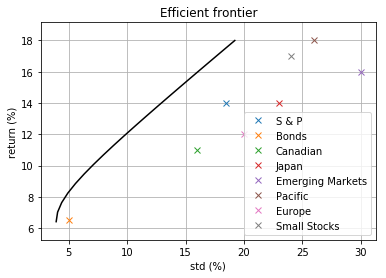

In [24]:
# plot frontier
xlim = ((rmin-0.1*dr), (rmax+0.1*dr))

for i, label in enumerate(assets['Label'].values): 
    plt.plot(np.sqrt(Q[i,i]), r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(np.sqrt(var0), mu0, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(xlim)
plt.legend(assets['Label'].values)
plt.grid()
plt.show()

## The frontier without short sales

In [25]:
# vector of expected returns
r = assets['Return (%)'].values

# covariance matrix
sigmas = np.diag(assets['STD (%)'].values)
Q = sigmas @ cov.values @ sigmas

# options
options = {
    'number_of_points': 20,
    'short': False
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'options': options
}
sol = client.call('frontier', data)

### Got solution?

In [26]:
frontier = sol['frontier']
m = len(frontier)
mu1 = np.zeros((m,))
var1 = np.zeros((m,))
pos1 = np.zeros((m, n))
for i, e in enumerate(frontier):
    point = e['sol']
    mu1[i] = e['mu']
    var1[i] = point['obj']
    pos1[i, :] = point['x']
    if point['obj'] is not None:
        print('  {}. mu = {:.3f}%, std = {:.3f}% ({})'.format(i+1, mu1[i], math.sqrt(var1[i]), point['status']))
    else:
        print('  {}. mu = {:.3f}%, std = --- ({})'.format(i+1, mu1[i], point['status']))

  1. mu = 6.889%, std = 4.874% (optimal)
  2. mu = 7.474%, std = 5.025% (optimal)
  3. mu = 8.059%, std = 5.382% (optimal)
  4. mu = 8.644%, std = 5.886% (optimal)
  5. mu = 9.228%, std = 6.502% (optimal)
  6. mu = 9.813%, std = 7.204% (optimal)
  7. mu = 10.398%, std = 7.969% (optimal)
  8. mu = 10.983%, std = 8.779% (optimal)
  9. mu = 11.568%, std = 9.625% (optimal)
  10. mu = 12.152%, std = 10.497% (optimal)
  11. mu = 12.737%, std = 11.389% (optimal)
  12. mu = 13.322%, std = 12.297% (optimal)
  13. mu = 13.907%, std = 13.217% (optimal)
  14. mu = 14.491%, std = 14.148% (optimal)
  15. mu = 15.076%, std = 15.087% (optimal)
  16. mu = 15.661%, std = 16.032% (optimal)
  17. mu = 16.246%, std = 16.984% (optimal)
  18. mu = 16.830%, std = 17.940% (optimal)
  19. mu = 17.415%, std = 18.900% (optimal)
  20. mu = 18.000%, std = 26.000% (optimal)


### Plot frontier

In [27]:
rmax = np.max(r)
rmin = np.min((np.min(r), np.min(mu0)))
dr = rmax - rmin
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

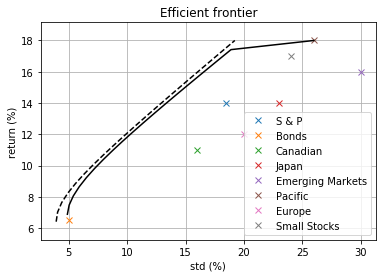

In [28]:
# plot frontier
xlim = ((rmin-0.1*dr), (rmax+0.1*dr))

for i, label in enumerate(assets['Label'].values): 
    plt.plot(np.sqrt(Q[i,i]), r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(np.sqrt(var0), mu0, 'k--')
plt.plot(np.sqrt(var1), mu1, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(xlim)
plt.legend(assets['Label'].values)
plt.grid()
plt.show()

## A strongly constrained frontier

In [29]:
# initial portfolio
x0 = assets['Initial (%)'].values/100

# cashflow
cashflow = 20/100

# options
options = {
    'number_of_points': 20,
    'sell': False
}

# prepare data for submitting request to api
data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'x0': x0.tolist(),
    'cashflow': cashflow,
    'options': options
}
sol = client.call('frontier', data)

### Got solution?

In [30]:
frontier = sol['frontier']
m = len(frontier)
mu2 = np.zeros((m,))
var2 = np.zeros((m,))
pos2 = np.zeros((m, n))
for i, e in enumerate(frontier):
    point = e['sol']
    mu2[i] = e['mu']
    var2[i] = point['obj']
    pos2[i, :] = point['x']
    if point['obj'] is not None:
        print('  {}. mu = {:.3f}%, std = {:.3f}% ({})'.format(i+1, mu2[i], math.sqrt(var2[i]), point['status']))
    else:
        print('  {}. mu = {:.3f}%, std = --- ({})'.format(i+1, mu2[i], point['status']))

  1. mu = 11.708%, std = 10.331% (optimal)
  2. mu = 12.039%, std = 10.761% (optimal)
  3. mu = 12.371%, std = 11.226% (optimal)
  4. mu = 12.702%, std = 11.711% (optimal)
  5. mu = 13.033%, std = 12.202% (optimal)
  6. mu = 13.364%, std = 12.699% (optimal)
  7. mu = 13.695%, std = --- (infeasible)
  8. mu = 14.026%, std = --- (infeasible)
  9. mu = 14.357%, std = --- (infeasible)
  10. mu = 14.689%, std = --- (infeasible)
  11. mu = 15.020%, std = --- (infeasible)
  12. mu = 15.351%, std = --- (infeasible)
  13. mu = 15.682%, std = --- (infeasible)
  14. mu = 16.013%, std = --- (infeasible)
  15. mu = 16.344%, std = --- (infeasible)
  16. mu = 16.675%, std = --- (infeasible)
  17. mu = 17.007%, std = --- (infeasible)
  18. mu = 17.338%, std = --- (infeasible)
  19. mu = 17.669%, std = --- (infeasible)
  20. mu = 18.000%, std = --- (infeasible)


### Plot frontier

In [31]:
rmax = np.max(r)
rmin = np.min((np.min(r), np.min(mu0)))
dr = rmax - rmin
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

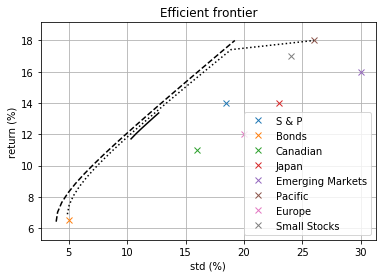

In [32]:
# plot frontier
xlim = ((rmin-0.1*dr), (rmax+0.1*dr))

for i, label in enumerate(assets['Label'].values): 
    plt.plot(np.sqrt(Q[i,i]), r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(np.sqrt(var0), mu0, 'k--')
plt.plot(np.sqrt(var1), mu1, 'k:')
plt.plot(np.sqrt(var2), mu2, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(xlim)
plt.legend(assets['Label'].values)
plt.grid()
plt.show()

### Plot sells, buys, positions

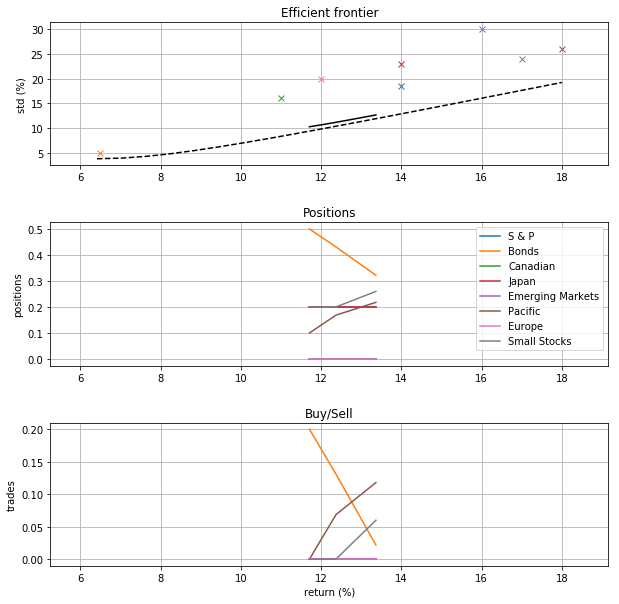

In [33]:
mu = mu2
var = var2
pos = pos2

# plot frontier
xlim = ((rmin-0.1*dr), (rmax+0.1*dr))
plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
for i, label in enumerate(assets['Label'].values): 
    plt.plot(r[i], np.sqrt(Q[i,i]), 'x', color=colors[np.mod(i, len(colors))])
ax.plot(mu0, np.sqrt(var0), 'k--')
ax.plot(mu, np.sqrt(var), 'k')
ax.set_ylabel('std (%)')
ax.set_title('Efficient frontier')
ax.set_xlim(xlim)
ax.grid()

ax = plt.subplot(3, 1, 2)
ax.plot(mu, pos)
ax.set_ylabel('positions')
ax.set_title('Positions')
ax.set_xlim(xlim)
ax.legend(assets['Label'].values)
ax.grid()

ax = plt.subplot(3, 1, 3)
ax.plot(mu, pos - x0)
ax.set_xlabel('return (%)')
ax.set_ylabel('trades')
ax.set_title('Buy/Sell')
ax.set_xlim(xlim)
ax.grid()

plt.subplots_adjust(hspace=.4)
plt.show()